# Caso Wines – Análisis PCA y Clusterización

Notebook reproducible para el caso *Wines*: análisis de componentes principales, selección de dimensiones, clusterización y comparación con segmentos reales de vinos.

In [18]:
# 0) Importar librerías necesarias
# Comentario: en este bloque cargamos todas las librerías que usaremos

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

%matplotlib inline
sns.set(style="whitegrid", context="notebook")

## 1. Carga y preparación de los datos

In [19]:
# 1.1) Cargar datasets de características químicas y segmentos reales
# Suponemos que el notebook está en la misma carpeta que wine-data.csv y wine-segments.csv

data = pd.read_csv("wine-data.csv")
segments = pd.read_csv("wine-segments.csv")

# Renombrar columna de segmentos para mayor claridad
segments.columns = ["Cultivar"]

# Unir en un solo DataFrame por índice
data_full = data.copy()
data_full["Cultivar"] = segments["Cultivar"].values

data_full.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Cultivar
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [20]:
# 1.2) Revisión rápida de estructura y estadísticos básicos

print("Dimensiones del dataset:", data_full.shape)
display(data_full.describe().T)

data_full.info()

Dimensiones del dataset: (178, 14)


,count,mean,std,min,25%,50%,75%,max
Alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
Malic_Acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
Ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
Ash_Alcanity,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
Magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
Total_Phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
Flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
Nonflavanoid_Phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
Proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
Color_Intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
 13  Cultivar              178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


## 2. Análisis de Componentes Principales (PCA)

En esta sección estandarizaremos las variables químicas, aplicaremos PCA y analizaremos la varianza explicada por cada componente.

In [21]:
# 2.1) Separar variables explicativas (X) y variable de segmento (y)

feature_cols = data.columns.tolist()  # todas las columnas de wine-data son numéricas
X = data_full[feature_cols].values
y = data_full["Cultivar"].values

X[:3], y[:3]

(array([[1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00,
         3.060e+00, 2.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00,
         1.065e+03],
        [1.320e+01, 1.780e+00, 2.140e+00, 1.120e+01, 1.000e+02, 2.650e+00,
         2.760e+00, 2.600e-01, 1.280e+00, 4.380e+00, 1.050e+00, 3.400e+00,
         1.050e+03],
        [1.316e+01, 2.360e+00, 2.670e+00, 1.860e+01, 1.010e+02, 2.800e+00,
         3.240e+00, 3.000e-01, 2.810e+00, 5.680e+00, 1.030e+00, 3.170e+00,
         1.185e+03]]),
 array([1, 1, 1]))

In [22]:
# 2.2) Estandarizar las variables
# Comentario: PCA es sensible a la escala de las variables,
# por lo que primero normalizamos a media 0 y varianza 1.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:3]

array([[ 1.51861254, -0.5622498 ,  0.23205254, -1.16959318,  1.91390522,
         0.80899739,  1.03481896, -0.65956311,  1.22488398,  0.25171685,
         0.36217728,  1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, -2.49084714,  0.01814502,
         0.56864766,  0.73362894, -0.82071924, -0.54472099, -0.29332133,
         0.40605066,  1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, -0.2687382 ,  0.08835836,
         0.80899739,  1.21553297, -0.49840699,  2.13596773,  0.26901965,
         0.31830389,  0.78858745,  1.39514818]])

In [23]:
# 2.3) Ajustar PCA sin fijar número de componentes para ver toda la varianza

pca_full = PCA()
pca_full.fit(X_scaled)

explained_var_ratio = pca_full.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var_ratio)

pca_var_df = pd.DataFrame({
    "Componente": np.arange(1, len(explained_var_ratio) + 1),
    "Varianza_Explicada": explained_var_ratio,
    "Varianza_Acumulada": cum_explained_var
})

pca_var_df

,Componente,Varianza_Explicada,Varianza_Acumulada
0,1,0.361988,0.361988
1,2,0.192075,0.554063
2,3,0.111236,0.665300
3,4,0.070690,0.735990
4,5,0.065633,0.801623
5,6,0.049358,0.850981
6,7,0.042387,0.893368
7,8,0.026807,0.920175
8,9,0.022222,0.942397
9,10,0.019300,0.961697


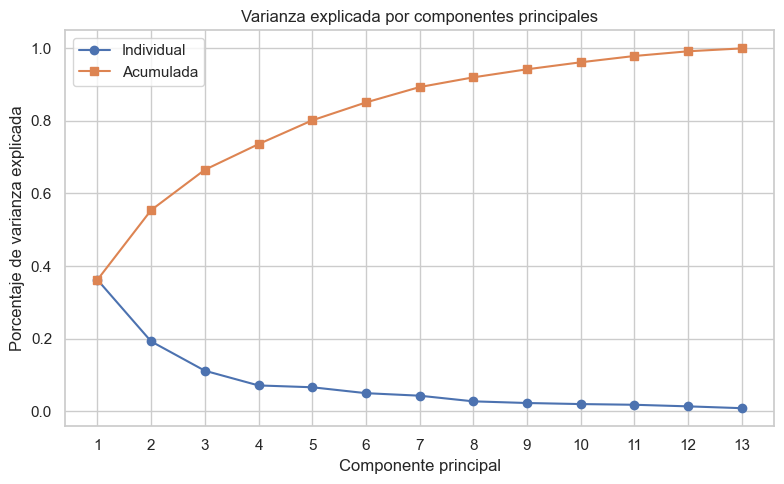

In [24]:
# 2.4) Gráfico de la varianza explicada (scree plot) y varianza acumulada

plt.figure(figsize=(8, 5))
plt.plot(pca_var_df["Componente"], pca_var_df["Varianza_Explicada"], marker="o", label="Individual")
plt.plot(pca_var_df["Componente"], pca_var_df["Varianza_Acumulada"], marker="s", label="Acumulada")
plt.xlabel("Componente principal")
plt.ylabel("Porcentaje de varianza explicada")
plt.title("Varianza explicada por componentes principales")
plt.xticks(pca_var_df["Componente"])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Selección de número de dimensiones

En este paso decidimos cuántos componentes principales conservar en el nuevo espacio dimensional.

In [25]:
# 3.1) Ver la varianza acumulada para los primeros componentes

pca_var_df.head(10)

,Componente,Varianza_Explicada,Varianza_Acumulada
0,1,0.361988,0.361988
1,2,0.192075,0.554063
2,3,0.111236,0.665300
3,4,0.070690,0.735990
4,5,0.065633,0.801623
5,6,0.049358,0.850981
6,7,0.042387,0.893368
7,8,0.026807,0.920175
8,9,0.022222,0.942397
9,10,0.019300,0.961697


In [26]:
# 3.2) Seleccionar la cantidad de dimensiones del nuevo espacio
# Comentario:
# - Para visualización bidimensional nos interesa usar 2 componentes.
# - Estos suelen explicar una fracción importante de la varianza total.
#   (ver tabla anterior de varianza acumulada).

n_components_pca = 2
print(f"Número de componentes seleccionados para el nuevo espacio: {n_components_pca}")

Número de componentes seleccionados para el nuevo espacio: 2


## 4. Reducción al nuevo espacio dimensional y visualización

Reducimos los datos al espacio de los primeros componentes principales seleccionados y graficamos los resultados.

In [27]:
# 4.1) Aplicar PCA con el número de componentes seleccionado

pca = PCA(n_components=n_components_pca)
X_pca = pca.fit_transform(X_scaled)

pca_cols = [f"PC{i+1}" for i in range(n_components_pca)]
df_pca = pd.DataFrame(X_pca, columns=pca_cols)
df_pca["Cultivar"] = y

df_pca.head()

,PC1,PC2,Cultivar
0,3.316751,1.443463,1
1,2.209465,-0.333393,1
2,2.516740,1.031151,1
3,3.757066,2.756372,1
4,1.008908,0.869831,1


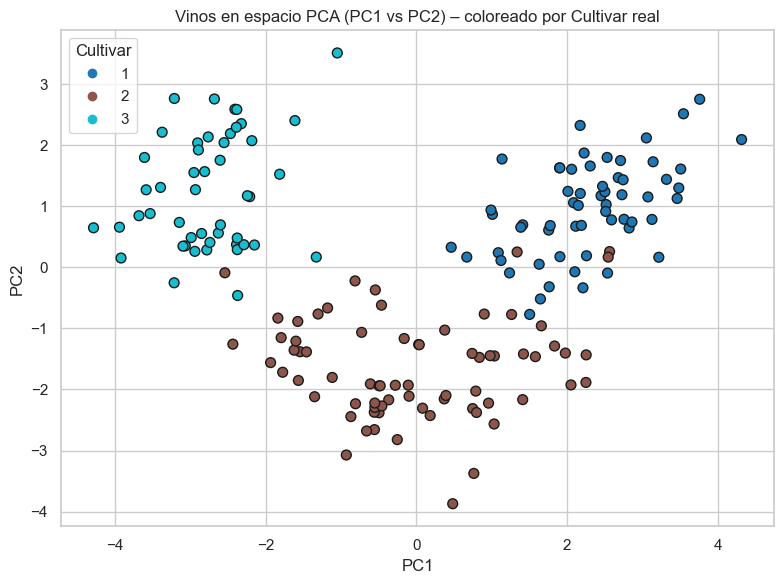

In [28]:
# 4.2) Gráfico en el nuevo espacio PCA coloreado por Cultivar real

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_pca["PC1"],
    df_pca["PC2"],
    c=df_pca["Cultivar"],
    cmap="tab10",
    s=50,
    edgecolor="k"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Vinos en espacio PCA (PC1 vs PC2) – coloreado por Cultivar real")
plt.legend(*scatter.legend_elements(), title="Cultivar")
plt.tight_layout()
plt.show()

> **Pregunta:** ¿Se aprecian clusters en el espacio de PC1 y PC2?

A simple vista debieran observarse grupos parcialmente separados que corresponden aproximadamente a los 3 cultivares.

## 5. Clusterización en el espacio PCA

En esta sección aplicaremos un algoritmo de clusterización (K-Means) sobre los datos proyectados en el espacio PCA y seleccionaremos la cantidad de clusters.

In [29]:
# 5.1) Evaluar distintos valores de k con K-Means usando el espacio PCA
# Comentario: usaremos tanto la inercia (método del codo) como el
# coeficiente de silueta promedio para ayudar a elegir la cantidad de clusters.

range_n_clusters = range(2, 8)  # probamos desde 2 hasta 7 clusters
inertias = []
silhouettes = []

for k in range_n_clusters:
    kmeans_k = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = kmeans_k.fit_predict(df_pca[pca_cols])
    inertias.append(kmeans_k.inertia_)
    silhouettes.append(silhouette_score(df_pca[pca_cols], labels_k))

results_df = pd.DataFrame({
    "k": list(range_n_clusters),
    "inertia": inertias,
    "silhouette": silhouettes
})

results_df

c:\Users\adria\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\adria\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\adria\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\adria\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Wi

,k,inertia,silhouette
0,2,628.788351,0.464914
1,3,259.509381,0.561051
2,4,192.390615,0.491421
3,5,155.189793,0.439095
4,6,122.712551,0.433361
5,7,99.388071,0.422202


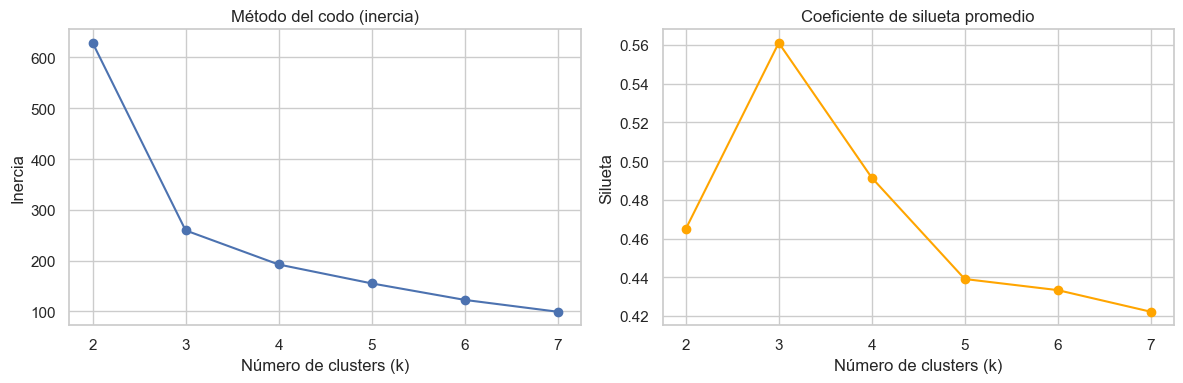

k = 2, silueta promedio = 0.465
k = 3, silueta promedio = 0.561
k = 4, silueta promedio = 0.491
k = 5, silueta promedio = 0.439
k = 6, silueta promedio = 0.433
k = 7, silueta promedio = 0.422


In [30]:
# 5.2) Graficar inercia (método del codo) y coeficiente de silueta

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(results_df["k"], results_df["inertia"], marker="o")
axes[0].set_title("Método del codo (inercia)")
axes[0].set_xlabel("Número de clusters (k)")
axes[0].set_ylabel("Inercia")
axes[0].grid(True)

axes[1].plot(results_df["k"], results_df["silhouette"], marker="o", color="orange")
axes[1].set_title("Coeficiente de silueta promedio")
axes[1].set_xlabel("Número de clusters (k)")
axes[1].set_ylabel("Silueta")
axes[1].grid(True)

plt.tight_layout()
plt.show()

for k, s in zip(results_df["k"], results_df["silhouette"]):
    print(f"k = {k}, silueta promedio = {s:.3f}")

In [31]:
# 5.3) Seleccionar cantidad de clusters (k) basada en la silueta
# Comentario: elegimos el k que maximiza el coeficiente de silueta.

best_k = int(results_df.loc[results_df["silhouette"].idxmax(), "k"])
print(f"Número de clusters seleccionado (según silueta): {best_k}")

# Ajustar K-Means final con best_k clusters en el espacio PCA
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters_pca = kmeans_final.fit_predict(df_pca[pca_cols])

# Guardar los labels de cluster
df_pca["Cluster"] = clusters_pca
data_full["Cluster"] = clusters_pca  # marcar dataset original con el número de cluster

data_full.head()

Número de clusters seleccionado (según silueta): 3


c:\Users\adria\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Cultivar,Cluster
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1,0


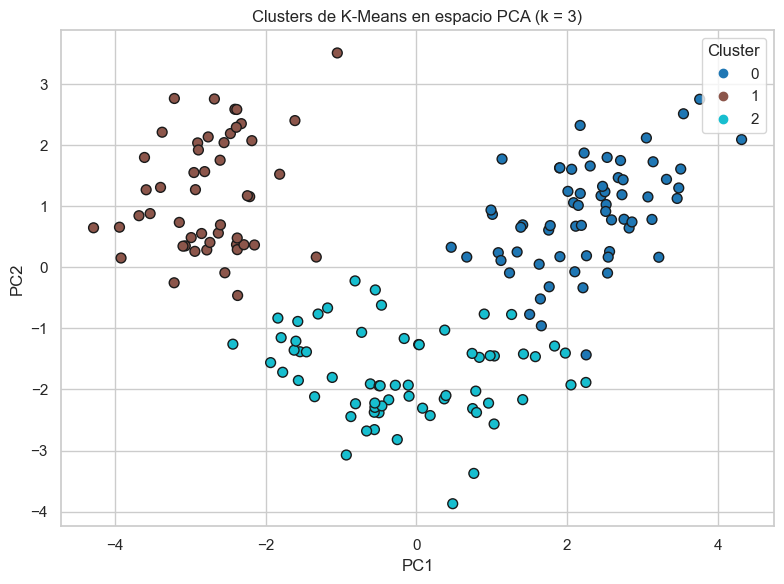

In [32]:
# 5.4) Visualizar los clusters encontrados en el espacio PCA

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_pca["PC1"],
    df_pca["PC2"],
    c=df_pca["Cluster"],
    cmap="tab10",
    s=50,
    edgecolor="k"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Clusters de K-Means en espacio PCA (k = {best_k})")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

## 6. Comparación con segmentos reales y conclusiones

In [33]:
# 6.1) Comparar clusters encontrados vs. Cultivar real

ct = pd.crosstab(data_full["Cultivar"], data_full["Cluster"], margins=True)
ct

Cluster,0,1,2,All
Cultivar,,,,
1,59,0,0,59
2,5,1,65,71
3,0,48,0,48
All,64,49,65,178


In [34]:
# 6.2) (Opcional) Medir calidad de la clusterización con un índice externo

ari = adjusted_rand_score(data_full["Cultivar"], data_full["Cluster"])
print(f"Índice de Rand Ajustado (ARI) entre clusters y cultivares reales: {ari:.3f}")

Índice de Rand Ajustado (ARI) entre clusters y cultivares reales: 0.895


### 6.3) Comentarios finales

- El PCA nos permitió reducir la dimensionalidad del problema y visualizar las observaciones en 2 componentes principales, manteniendo gran parte de la varianza original.
- Sobre este espacio reducido, K-Means encontró grupos basados en similitud de las características químicas de los vinos.
- La comparación con los cultivares reales (tabla de contingencia y ARI) nos da una idea de qué tan bien la clusterización no supervisada recupera la estructura "verdadera" de las clases.
- Un ARI cercano a 1 indica muy buen acuerdo; valores cercanos a 0 indican que los clusters no se parecen mucho a los cultivares reales.
- En un contexto real, estos análisis ayudan a entender si la segmentación basada solo en características químicas es suficiente para distinguir tipos de vino o si se requieren más variables o modelos más sofisticados.

### 6.4) Preguntas para resolver con este caso

1. Usando la tabla `pca_var_df`, ¿cuánta varianza explica el **primer componente (PC1)**? Escribe el valor en porcentaje.  
   *Tip:* Ejecuta la celda donde se muestra `pca_var_df` y toma el valor de la columna `Varianza_Explicada` para `Componente = 1` (primera fila). Luego multiplícalo por 100 para obtener el porcentaje.

2. Según `pca_var_df`, ¿cuánta **varianza acumulada** explican **PC1 y PC2 juntos**? ¿Es más del 50%?  
   *Tip:* En la misma tabla `pca_var_df`, mira la fila donde `Componente = 2` y toma el valor de la columna `Varianza_Acumulada`. Compáralo con 0.50 (50%).

3. Mira el gráfico PC1 vs PC2 coloreado por `Cultivar`: ¿se distinguen **aproximadamente 3 grupos** o los puntos se ven muy mezclados? Describe brevemente lo que observas.  
   *Tip:* Vuelve a ejecutar la celda del gráfico de PCA (PC1 vs PC2). Fíjate si los colores (cultivares) forman nubes separadas o si se superponen mucho.

4. Observa la tabla de resultados de `results_df`: ¿para qué valor de **k** el coeficiente de **silueta** es mayor? Escribe ese valor de k.  
   *Tip:* Ejecuta la celda que imprime `results_df` (o el bucle que muestra `k` y silueta). Busca la fila con el valor más alto en la columna `silhouette` y anota el `k` correspondiente.

5. Con la tabla de contingencia entre `Cultivar` y `Cluster`, responde: ¿para qué **Cultivar** parece haber un cluster donde la mayoría de sus vinos caen en la misma columna (cluster)?  
   *Tip:* Ejecuta la celda que calcula `ct = pd.crosstab(...)`. Para cada fila (Cultivar), identifica la columna (Cluster) con el número más alto. Esa combinación indica buena correspondencia.

6. Mira el valor del Índice de Rand Ajustado (ARI) que se imprime: si está **cerca de 1**, ¿qué significa? ¿Y si estuviera **cerca de 0**? Explica en una o dos frases.  
   *Tip:* Revisa la celda donde se imprime el `ari`. Piensa en “1” como *acuerdo perfecto* entre clusters y cultivares, y en “0” como *acuerdo similar al azar*.

**Interpretación del ARI**  
   - **ARI alto (cerca de 1)**: los clusters de K-Means se parecen mucho a los cultivares reales → **muy buena calidad** de clusterización.  
   - **ARI medio**: hay cierta relación entre clusters y cultivares, pero con bastantes errores → **calidad moderada**.  
   - **ARI bajo (cerca de 0)**: los clusters se parecen poco a los cultivares → la clusterización no está capturando bien la estructura real.